Continuation of  1. EDA on CSV - Topic Modelling 

# 4. Clustering of Coloumn Names


We are going top use LDA topic Modelling. We are hopeful that it would cluster the similar coloumn names together. Then we can focus on the relevant Topics and then try to merge them together. 

Ref for Topic Modelling -> https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

In [1]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)



# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [3]:
df = pd.read_csv("F:/Environmental Baseline Data/Version 2/Data/CSV Metadata/Shape_UBC_Baseline.csv")
# df = pd.read_csv("F:/D&IMBU/DataScience/2019.10.07 - Environmental Baseline Team Project/Demo Deliverables/Demo ubc csvs Matadata/Shape_UBC_Baseline.csv")
df.head(5)

                 
df_coloumns = pd.read_csv("F:/Environmental Baseline Data/Version 2/Data/CSV Metadata/coloumn_Names_UBC_Baseline.csv") 
#df_coloumns = pd.read_csv("F:/D&IMBU/DataScience/2019.10.07 - Environmental Baseline Team Project/Demo Deliverables/Demo ubc csvs Matadata/coloumn_Names_UBC_Baseline.csv")
df_coloumns.head(5)

C:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Unnamed: 0,Link,Col 1,Col 2,Col 3,Col 4,Col 5,Col 6,Col 7,Col 8,...,Col 66,Col 67,Col 68,Col 69,Col 70,Col 71,Col 72,Col 73,Col 74,Col 75
0,0,F:/Environmental Baseline Data/Version 2/Data/...,Assessment Scenario,Issue,Magnitude/Extent1,Duration2,Reversible/ Non-Reversible3,Potential for Measurable Contribution to Cumul...,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,F:/Environmental Baseline Data/Version 2/Data/...,Site Series,Hypothetical Baseline,Unnamed: 2,Baseline,Unnamed: 4,Construction,Unnamed: 6,Unnamed: 7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,F:/Environmental Baseline Data/Version 2/Data/...,Structural Stage,Hypothetical Baseline,Unnamed: 2,Baseline,Unnamed: 4,Construction,Unnamed: 6,Unnamed: 7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,F:/Environmental Baseline Data/Version 2/Data/...,Assessment Scenario,Issue/ Measurable Parameter,Magnitude/ Extent1,Duration2,Reversible/ Non-Reversible3,Potential for Measurable Contribution to Cumul...,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,F:/Environmental Baseline Data/Version 2/Data/...,Assessment Scenario,Issue/Measurable Parameter,Magnitude/ Extent1,Duration2,Reversible/ Non-Reversible3,Potential for Measurable Contribution to Cumul...,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
# Let's look at the Imported Dataset once again
print(df.Link.unique())
df.head()

['F:/Environmental Baseline Data/Version 2/Data/CSV/A0H8C0 %2D 13.0 EIA %2D Section 13.1 to 13.6 -page-100-table-1.csv'
 'F:/Environmental Baseline Data/Version 2/Data/CSV/A0H8C0 %2D 13.0 EIA %2D Section 13.1 to 13.6 -page-101-table-1.csv'
 'F:/Environmental Baseline Data/Version 2/Data/CSV/A0H8C0 %2D 13.0 EIA %2D Section 13.1 to 13.6 -page-105-table-1.csv'
 ...
 'F:/Environmental Baseline Data/Version 2/Data/CSV/B9%2D7 %2D V5C_TR_5C9_01of20_VEGETATION %2D A3S2I7-page-98-table-1.csv'
 'F:/Environmental Baseline Data/Version 2/Data/CSV/B9%2D7 %2D V5C_TR_5C9_01of20_VEGETATION %2D A3S2I7-page-98-table-2.csv'
 'F:/Environmental Baseline Data/Version 2/Data/CSV/B9%2D7 %2D V5C_TR_5C9_01of20_VEGETATION %2D A3S2I7-page-99-table-1.csv']


,Unnamed: 0,Link,Postal,Row_Numbers,Coloumn_Numbers,File_Name,Coloumn_Names
0,0,F:/Environmental Baseline Data/Version 2/Data/...,A0H8C0,6,6,A0H8C0 %2D 13.0 EIA %2D Section 13.1 to 13.6 -...,Assessment Scenario ...
1,1,F:/Environmental Baseline Data/Version 2/Data/...,A0H8C0,11,14,A0H8C0 %2D 13.0 EIA %2D Section 13.1 to 13.6 -...,Site Series Hypothetical Baseline ...
2,2,F:/Environmental Baseline Data/Version 2/Data/...,A0H8C0,10,14,A0H8C0 %2D 13.0 EIA %2D Section 13.1 to 13.6 -...,Structural Stage Hypothetical Baseline ...
3,3,F:/Environmental Baseline Data/Version 2/Data/...,A0H8C0,5,6,A0H8C0 %2D 13.0 EIA %2D Section 13.1 to 13.6 -...,Assessment Scenario Issue/ Measurable Parame...
4,4,F:/Environmental Baseline Data/Version 2/Data/...,A0H8C0,6,6,A0H8C0 %2D 13.0 EIA %2D Section 13.1 to 13.6 -...,Assessment Scenario Issue/Measurable Paramet...


In [5]:
# Convert to list
list_documents = df.Coloumn_Names.values.tolist()

# Remove Emails
#data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
# data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
# data = [re.sub("\'", "", sent) for sent in data]

pprint(list_documents[:5])

['  Assessment Scenario                                              Issue  '
 '\\\n'
 '0        Construction  Community Diversity-effects from ROW preparati...   \n'
 '\n'
 '  Magnitude/Extent1 Duration2 Reversible/ Non-Reversible3  \\\n'
 '0               Low       NaN                         NaN   \n'
 '\n'
 '  Potential for Measurable Contribution to Cumulative Effects4  \n'
 '0                                                 No            ',
 '   Site Series Hypothetical Baseline            Unnamed: 2    Baseline  \\\n'
 '0  Site Series            Area  (ha)  % of Mapped Corridor  Area  (ha)   \n'
 '\n'
 '                             Unnamed: 4 Construction               Unnamed: '
 '6  \\\n'
 '0  % Change from Hypothetical Baseline1   Area  (ha)  % Change from '
 'Baseline1   \n'
 '\n'
 '                             Unnamed: 7 Operations With Project  \\\n'
 '0  % Change from Hypothetical Baseline1              Area  (ha)   \n'
 '\n'
 '                Unnamed: 9                  

In [6]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(list_documents))

print(data_words[:1])

[['assessment', 'scenario', 'issue', 'construction', 'community', 'diversity', 'effects', 'from', 'row', 'preparati', 'magnitude', 'extent', 'duration', 'reversible', 'non', 'reversible', 'low', 'nan', 'nan', 'potential', 'for', 'measurable', 'contribution', 'to', 'cumulative', 'effects', 'no']]


In [42]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=50) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=50)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['assessment_scenario', 'issue', 'construction', 'community', 'diversity', 'effects', 'from', 'row', 'preparati', 'magnitude', 'extent', 'duration', 'reversible_non', 'reversible', 'low', 'nan', 'nan', 'potential', 'for', 'measurable_contribution', 'to', 'cumulative', 'effects', 'no']


In [43]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
stop_words.extend(['nan', 'nan ', 'unnamed'])

# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

#Callthing these functions now
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
word_tokens_bigrams = make_bigrams(data_words_nostops)

In [44]:
input_id2word = corpora.Dictionary(word_tokens_bigrams)
text_corpus = word_tokens_bigrams

## convert the dictionary into the bag-of-words (BoW)/document term matrix
td_frequency = [input_id2word.doc2bow(text) for text in text_corpus]
print(td_frequency)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [45]:
# Human readable format of corpus (term-frequency)
# [[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]
nTopics = 20
nTopics

20

In [46]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=td_frequency,
                                           id2word=input_id2word,
                                           num_topics = nTopics, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [47]:
#pprint(lda_model.print_topics())
doc_lda = lda_model[td_frequency]

In [48]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())

[(0,
  '0.284*"quality" + 0.219*"change" + 0.000*"ss_ss" + 0.000*"sediment" + '
  '0.000*"sample" + 0.000*"parameter" + 0.000*"ocean_disposal" + '
  '0.000*"isqg_pel" + 0.000*"marine" + 0.000*"guideline"'),
 (1,
  '0.263*"method" + 0.151*"crossing" + 0.130*"habitat" + 0.115*"status" + '
  '0.112*"species" + 0.088*"recommended" + 0.039*"wildlife" + '
  '0.026*"conservation" + 0.022*"issue" + 0.010*"concerns"'),
 (2,
  '0.279*"id" + 0.238*"distance" + 0.090*"within" + 0.078*"range" + '
  '0.034*"level" + 0.033*"environmental" + 0.026*"areas" + 0.025*"along" + '
  '0.023*"rationale" + 0.023*"field"'),
 (3,
  '0.492*"name" + 0.203*"common" + 0.177*"scientific" + 0.081*"drainage" + '
  '0.005*"soils" + 0.005*"well" + 0.003*"medium" + 0.001*"lands" + '
  '0.001*"emission_rate" + 0.000*"limitation"'),
 (4,
  '0.269*"type" + 0.138*"description" + 0.124*"rsa" + 0.116*"wetland" + '
  '0.086*"primary" + 0.067*"lsa" + 0.047*"code" + 0.036*"natural" + '
  '0.000*"proposed" + 0.000*"pipeline"'),
 (5

In [49]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(td_frequency))  #a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts = word_tokens_bigrams, dictionary = input_id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -15.26650463934284

Coherence Score:  0.4177227301359793


In [50]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, td_frequency, input_id2word)
vis

C:\Anaconda\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6     -0.205849 -0.002213       1        1  27.603022
2      0.204439  0.029327       2        1   8.960634
1      0.249697  0.318300       3        1   8.445094
12     0.112355  0.005148       4        1   6.060393
18     0.065371  0.001795       5        1   5.595755
3      0.261798 -0.349351       6        1   5.203560
16     0.084045  0.002870       7        1   5.028526
8      0.127026  0.006649       8        1   4.850658
5      0.128109  0.006680       9        1   4.640119
4      0.046023  0.000878      10        1   4.010971
19    -0.080161 -0.002216      11        1   3.399326
13     0.058173  0.001430      12        1   2.742339
14    -0.086646 -0.002287      13        1   2.707047
17    -0.054872 -0.001872      14        1   2.678560
9     -0.133164 -0.002614      15        1   2.390732
15    -0.114886 -0.002521      16        1   1.640313
10    -0.110438 -0.002494      17        1   1.513812
0     -0.173980 -0.002587      18        1   1.041511
7     -0.183092 -0.002523      19        1   0.945195
11    -0.193946 -0.002399      20        1   0.542430, topic_info=      Category          Freq                     Term         Total  loglift  \
27     Default  23595.000000                  project  23595.000000  30.0000   
29     Default  16929.000000                     site  16929.000000  29.0000   
282    Default  16928.000000                     name  16928.000000  28.0000   
14     Default  15379.000000                potential  15379.000000  27.0000   
280    Default  16505.000000                       id  16505.000000  26.0000   
189    Default  10925.000000                     date  10925.000000  25.0000   
353    Default  12805.000000               provincial  12805.000000  24.0000   
655    Default  14663.000000                   method  14663.000000  23.0000   
263    Default  27031.000000                      cid  27031.000000  22.0000   
322    Default  14121.000000                 distance  14121.000000  21.0000   
18     Default   9108.000000                     area   9108.000000  20.0000   
193    Default   7417.000000                     fish   7417.000000  19.0000   
22     Default   8015.000000                       ha   8015.000000  18.0000   
240    Default   8214.000000                   effect   8214.000000  17.0000   
102    Default   7149.000000                     type   7149.000000  16.0000   
389    Default   8432.000000                 crossing   8432.000000  15.0000   
100    Default   6829.000000                   number   6829.000000  14.0000   
123    Default   6985.000000                   common   6985.000000  13.0000   
661    Default   7271.000000               mitigation   7271.000000  12.0000   
7      Default   5797.000000                  effects   5797.000000  11.0000   
358    Default   6111.000000               scientific   6111.000000  10.0000   
42     Default   7259.000000                  habitat   7259.000000   9.0000   
119    Default   5981.000000                    class   5981.000000   8.0000   
2      Default   5860.000000             construction   5860.000000   7.0000   
200    Default   5281.000000                 location   5281.000000   6.0000   
163    Default   6447.000000                   status   6447.000000   5.0000   
62     Default   4364.000000                    total   4364.000000   4.0000   
43     Default   6277.000000                  species   6277.000000   3.0000   
73     Default   3904.000000                 activity   3904.000000   2.0000   
57     Default   3399.000000                       km   3399.000000   1.0000   
...        ...           ...                      ...           ...      ...   
2906   Topic20      0.130033                technical     11.596000   0.7262   
839    Topic20      0.130033                   report     11.596146   0.7262   
1502   Topic20      0.130026                    y

In [51]:
pyLDAvis.save_html(vis,'lda_vis_unnnamed.html')

In [52]:
def format_topics_sentences(ldamodel=None, corpus = td_frequency, texts = None):
    # Init output
    sent_topics_df = pd.DataFrame()
    
    #print('Total length is:', len(ldamodel[corpus]))
    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        #print('Iteration', i)
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        #print('Length of row', len(row))
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            #print('In row', j)
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Percentage_Contribution', 'Topic_Keywords']
    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    #return sent topics dataframe
    return(sent_topics_df)

In [53]:
# NOT VERY SURE ABOUT THE LOGIC FOR THIS PART OF THE CODE
#Topic map to match topics of pyLDAvis to other visualizations below. Both visualizations use models that assign topic numbers
#independently. This map will be used to make the topic number consistent across all visualizations
# topic_map = [0,1,2,3,4] # 
df.Link

0        F:/Environmental Baseline Data/Version 2/Data/...
1        F:/Environmental Baseline Data/Version 2/Data/...
2        F:/Environmental Baseline Data/Version 2/Data/...
3        F:/Environmental Baseline Data/Version 2/Data/...
4        F:/Environmental Baseline Data/Version 2/Data/...
5        F:/Environmental Baseline Data/Version 2/Data/...
6        F:/Environmental Baseline Data/Version 2/Data/...
7        F:/Environmental Baseline Data/Version 2/Data/...
8        F:/Environmental Baseline Data/Version 2/Data/...
9        F:/Environmental Baseline Data/Version 2/Data/...
10       F:/Environmental Baseline Data/Version 2/Data/...
11       F:/Environmental Baseline Data/Version 2/Data/...
12       F:/Environmental Baseline Data/Version 2/Data/...
13       F:/Environmental Baseline Data/Version 2/Data/...
14       F:/Environmental Baseline Data/Version 2/Data/...
15       F:/Environmental Baseline Data/Version 2/Data/...
16       F:/Environmental Baseline Data/Version 2/Data/.

In [54]:
df_topic_sents_keywords = format_topics_sentences(ldamodel = lda_model, corpus = td_frequency, texts = df.Link)

#Create dataframe that contains information about domainant topics for document corpus
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Table_No', 'Dominant_Topic', 'Topic_Percentage_Contrib', 'Keywords', 'Table_Links']


# Check this part of the code again as there were N/As in the list 
print(len(df_dominant_topic))
df_dominant_topic = df_dominant_topic[:25]
print(len(df_dominant_topic))
df_dominant_topic.head(5)

25052
25


,Table_No,Dominant_Topic,Topic_Percentage_Contrib,Keywords,Table_Links
0,0,19.0,0.1972,"effects, cont, cumulative, surface, characteri...",F:/Environmental Baseline Data/Version 2/Data/...
1,1,16.0,0.3573,"area, ha, class, soil, series, footprint, data...",F:/Environmental Baseline Data/Version 2/Data/...
2,2,16.0,0.3278,"area, ha, class, soil, series, footprint, data...",F:/Environmental Baseline Data/Version 2/Data/...
3,3,10.0,0.2722,"key, high, low, moderate, measurable, baseline...",F:/Environmental Baseline Data/Version 2/Data/...
4,4,10.0,0.2179,"key, high, low, moderate, measurable, baseline...",F:/Environmental Baseline Data/Version 2/Data/...


In [55]:
df.head(5)

,Unnamed: 0,Link,Postal,Row_Numbers,Coloumn_Numbers,File_Name,Coloumn_Names
0,0,F:/Environmental Baseline Data/Version 2/Data/...,A0H8C0,6,6,A0H8C0 %2D 13.0 EIA %2D Section 13.1 to 13.6 -...,Assessment Scenario ...
1,1,F:/Environmental Baseline Data/Version 2/Data/...,A0H8C0,11,14,A0H8C0 %2D 13.0 EIA %2D Section 13.1 to 13.6 -...,Site Series Hypothetical Baseline ...
2,2,F:/Environmental Baseline Data/Version 2/Data/...,A0H8C0,10,14,A0H8C0 %2D 13.0 EIA %2D Section 13.1 to 13.6 -...,Structural Stage Hypothetical Baseline ...
3,3,F:/Environmental Baseline Data/Version 2/Data/...,A0H8C0,5,6,A0H8C0 %2D 13.0 EIA %2D Section 13.1 to 13.6 -...,Assessment Scenario Issue/ Measurable Parame...
4,4,F:/Environmental Baseline Data/Version 2/Data/...,A0H8C0,6,6,A0H8C0 %2D 13.0 EIA %2D Section 13.1 to 13.6 -...,Assessment Scenario Issue/Measurable Paramet...


In [78]:
# Function to remove the stopwords in the coloumn list and convert to lower case
def lower_stop_string(strclean):
    strclean = strclean.lower()
    strclean = remove_stopwords(strclean)
    return strclean

In [79]:
# merging the DF of rows and coloumns with Dominant topic DF 

df_coloumns_Topics = (df.merge(df_dominant_topic, left_on = 'Link', right_on = 'Table_Links'))

#Dropping unnecessary coloumns after merging 
del df_coloumns_Topics['Table_Links']
del df_coloumns_Topics['Table_No']


df.head(5)

#Saving the results as CSVs
df_coloumns_Topics.to_csv('Dominant_Topic_Coloumns_Shape_CSV.csv')

In [80]:
df_coloumns_Topics.head(7)

,Unnamed: 0,Link,Postal,Row_Numbers,Coloumn_Numbers,File_Name,Coloumn_Names,Dominant_Topic,Topic_Percentage_Contrib,Keywords
0,0,F:/D&IMBU/DataScience/2019.10.07 - Environment...,A4F2Z2,6,4,01 ESA MAIN Section01to05 %2D A4F2Z2-page-20-t...,Filing Manu...,1.0,0.7249,"application, filing, requirement, references, ..."
1,1,F:/D&IMBU/DataScience/2019.10.07 - Environment...,A4F2Z2,13,4,01 ESA MAIN Section01to05 %2D A4F2Z2-page-21-t...,Filing Manual No. Filing Requirement...,1.0,0.9770,"application, filing, requirement, references, ..."
2,2,F:/D&IMBU/DataScience/2019.10.07 - Environment...,A4F2Z2,12,4,01 ESA MAIN Section01to05 %2D A4F2Z2-page-22-t...,Filing Manual No. Filing ...,1.0,0.9790,"application, filing, requirement, references, ..."
3,3,F:/D&IMBU/DataScience/2019.10.07 - Environment...,A4F2Z2,15,4,01 ESA MAIN Section01to05 %2D A4F2Z2-page-23-t...,Filing Manual No. ...,1.0,0.9834,"application, filing, requirement, references, ..."
4,4,F:/D&IMBU/DataScience/2019.10.07 - Environment...,A4F2Z2,12,4,01 ESA MAIN Section01to05 %2D A4F2Z2-page-24-t...,Filing Manual No. Filing Requirement \\n0 ...,1.0,0.9807,"application, filing, requirement, references, ..."
5,5,F:/D&IMBU/DataScience/2019.10.07 - Environment...,A4F2Z2,7,2,01 ESA MAIN Section01to05 %2D A4F2Z2-page-25-t...,Technical Component Project Details\n0 ...,1.0,0.9714,"application, filing, requirement, references, ..."
6,6,F:/D&IMBU/DataScience/2019.10.07 - Environment...,A4F2Z2,11,2,01 ESA MAIN Section01to05 %2D A4F2Z2-page-26-t...,Technical Com...,3.0,0.9778,"construction, pipeline, right, way, major, act..."


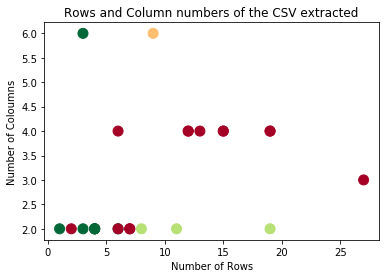

In [81]:
fig,ax = plt.subplots()

norm = plt.Normalize(1,4)
cmap = plt.cm.RdYlGn

sc = plt.scatter(df_coloumns_Topics['Row_Numbers'],
                 df_coloumns_Topics['Coloumn_Numbers'],
                 c=df_coloumns_Topics['Dominant_Topic'], 
                 s=100, cmap=cmap, norm=norm)
plt.xlabel('Number of Rows')
plt.ylabel('Number of Coloumns')
plt.title('Rows and Column numbers of the CSV extracted')

plt.show()

# Determining what Each topic is about

## 1. Word Clouds 

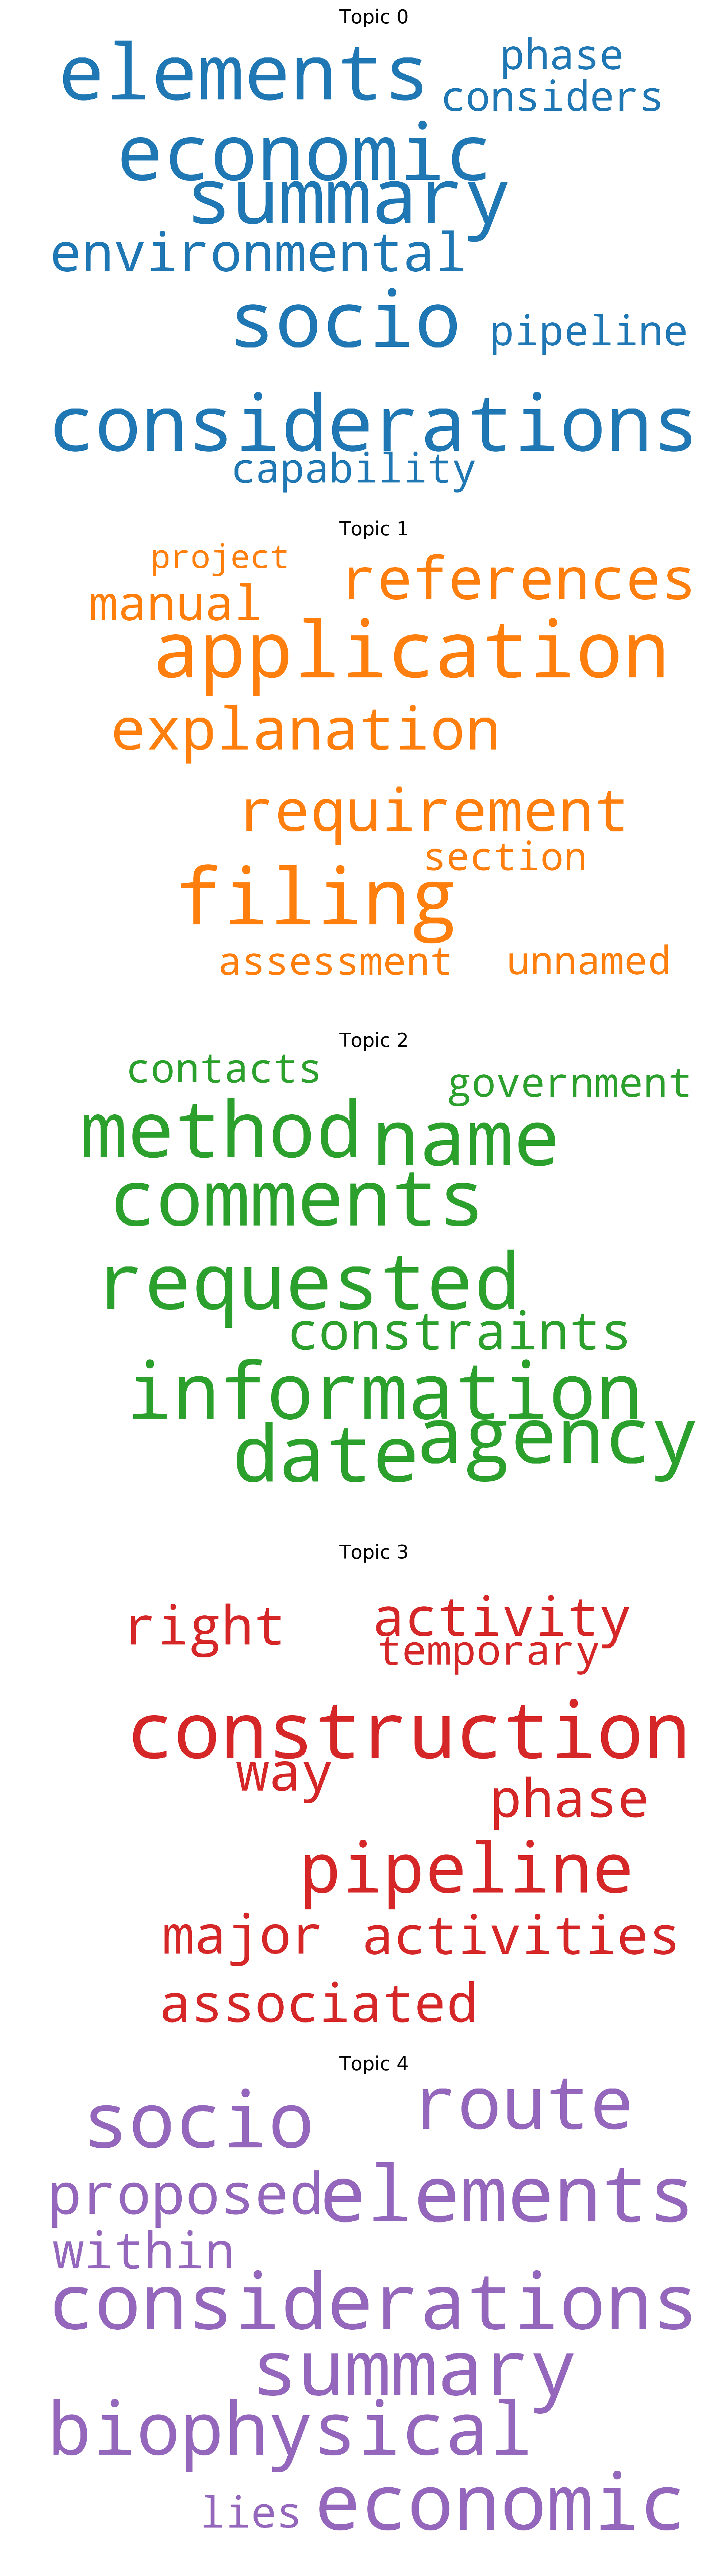

In [82]:
#Import required visualizations modules
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors
#Assign colors for each plot

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  
# more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False, num_topics=5) #Assign topics

cols += cols
fig, axes = plt.subplots(5, 1, figsize=(30, 30), sharex=True, sharey=True, dpi = 240)

for i, ax in enumerate(axes.flatten()): #Iterate for all subplots
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1]) 
    cloud.generate_from_frequencies(topic_words, max_font_size=300) #Generate wordcloud
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.savefig('wordclouds.svg') #Save figure as svg. Svg files do not pixelate when opened in a web browser
#plt.show()

## Double Bar Plot - Weight and Wordcount for each word
I guess this would not be required, but why not

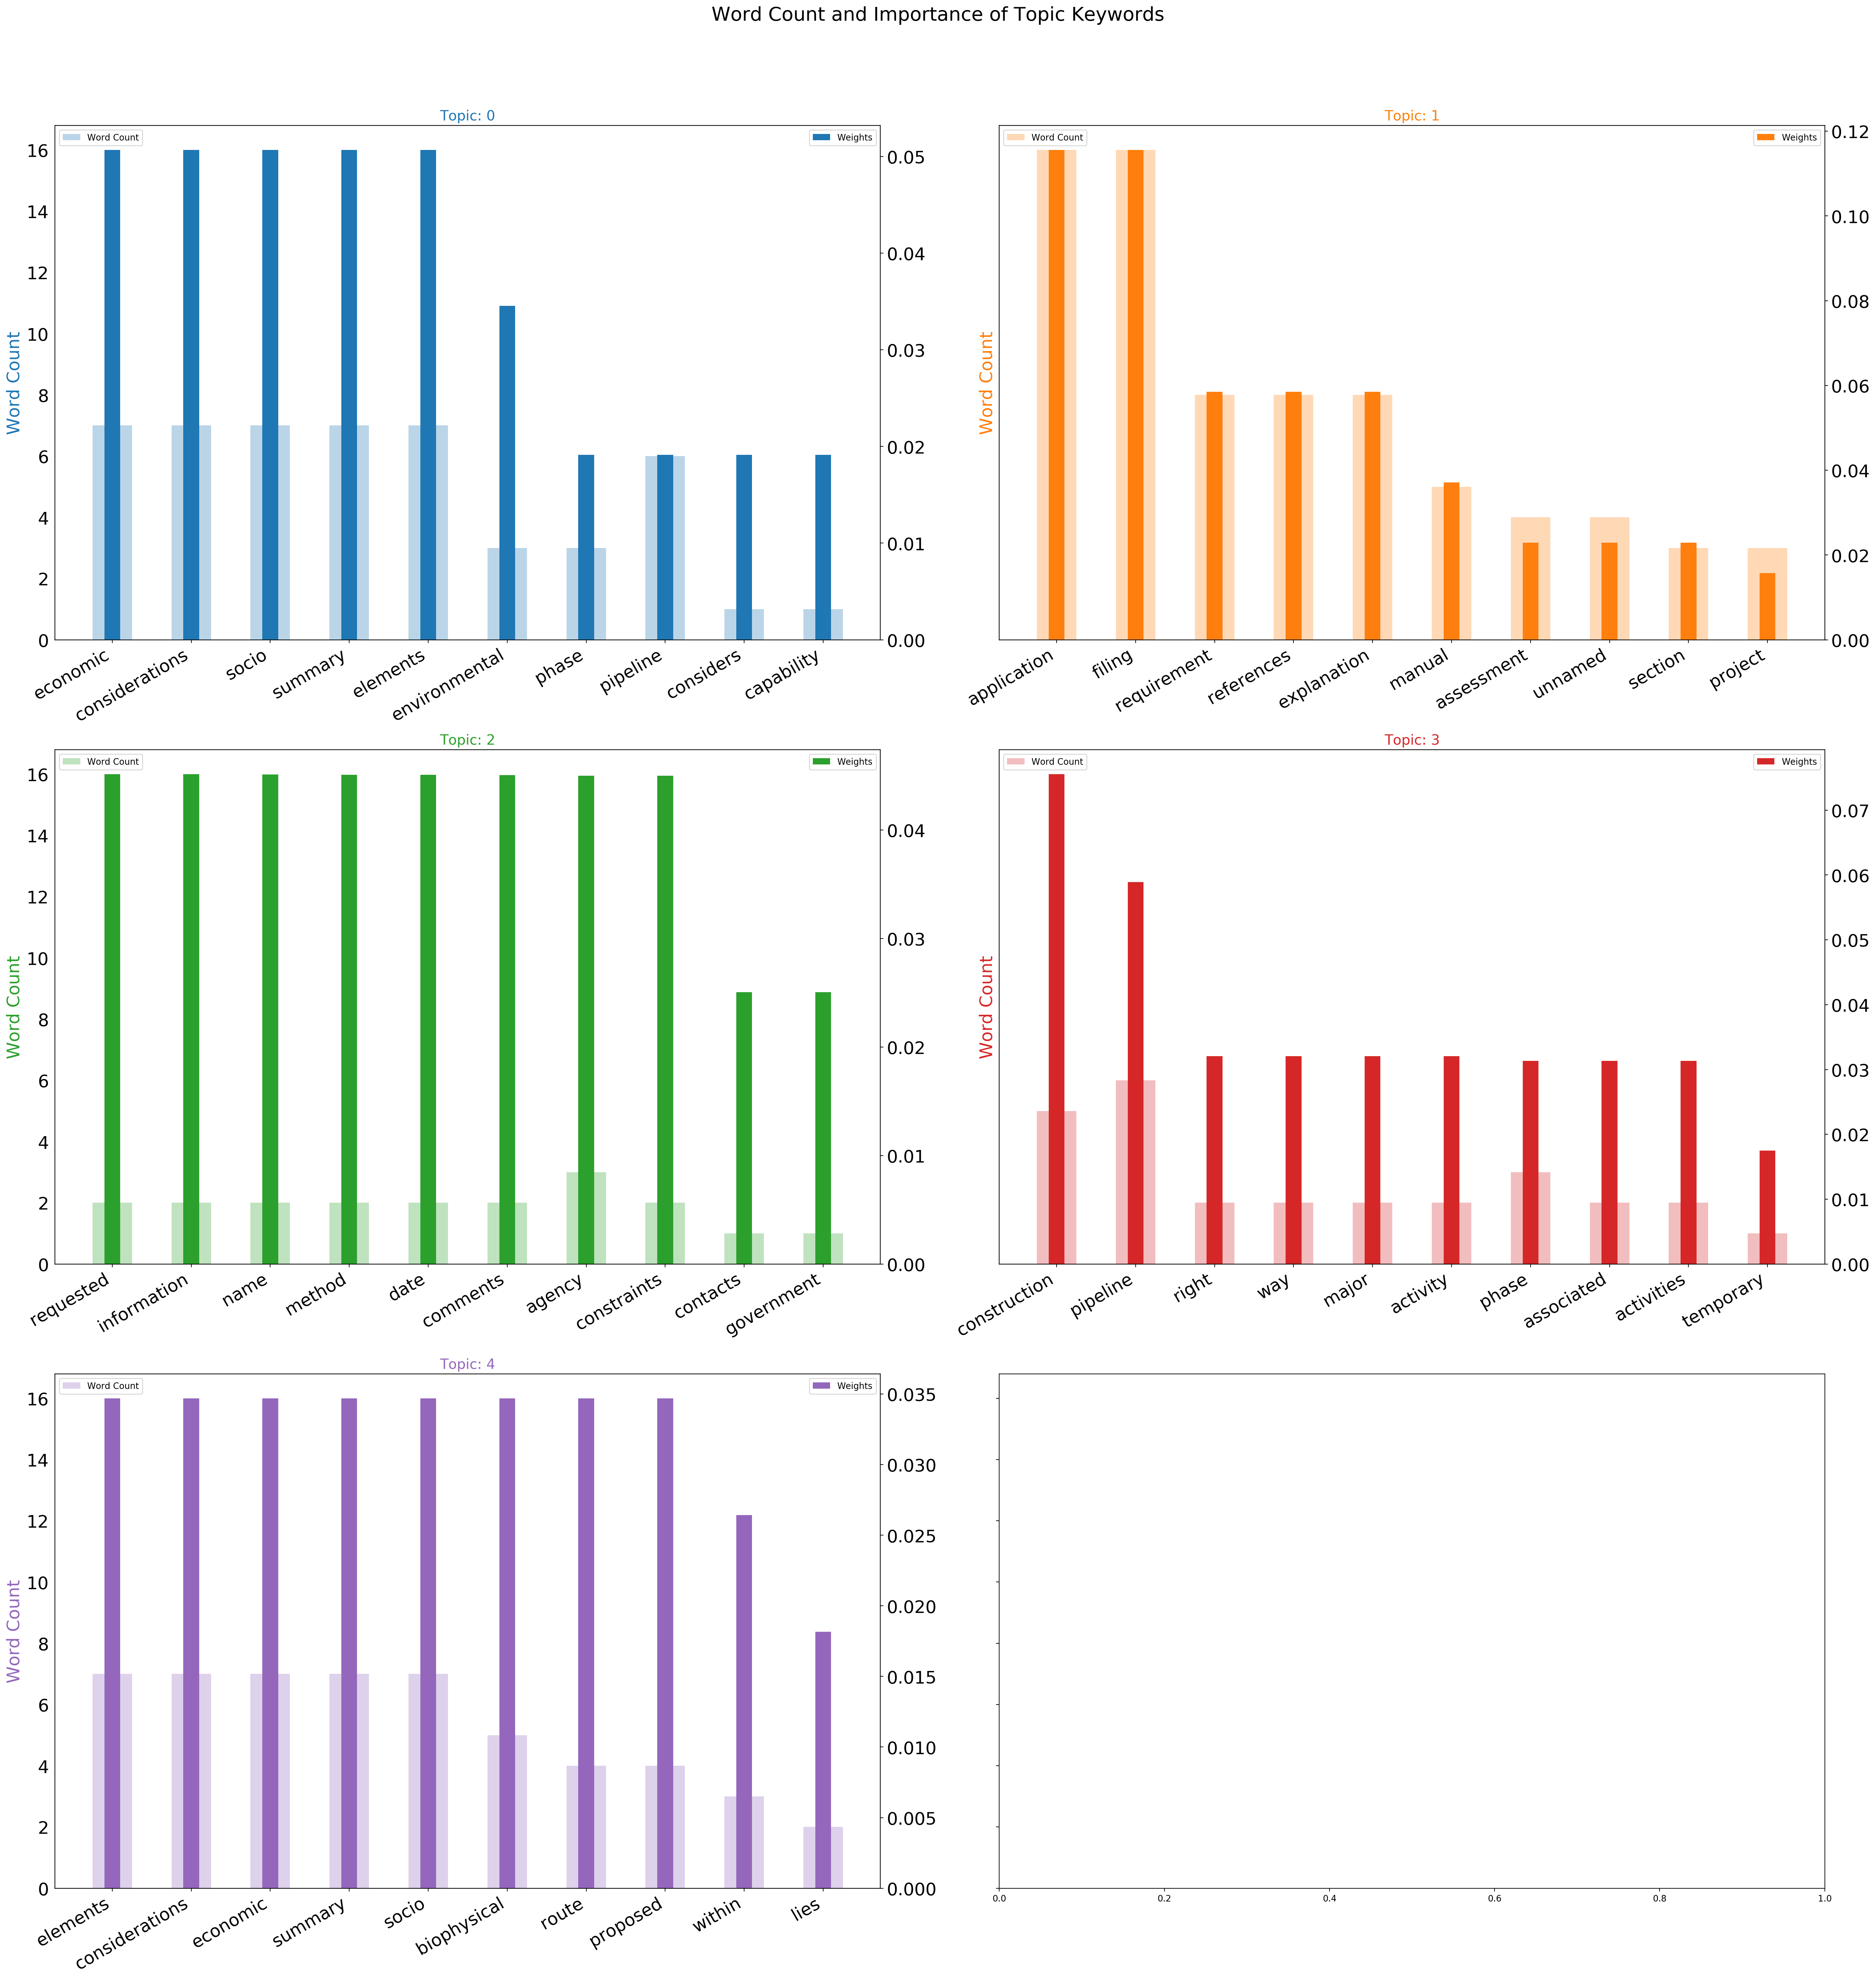

In [93]:
from collections import Counter

topics = lda_model.show_topics(formatted=False, num_topics=5) #assign topics
data_flat = [w for w_list in text_corpus for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics: #Store the weight and wordcount for each word
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(3, 2, figsize=(30, 30), sharey=True, dpi=200)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
cols += cols #Increase the number of colors to 20
for i, ax in enumerate(axes.flatten()):
    if i < 5:
        '''if len(df.loc[df.topic_id == i, 'word']) == 0:
        continue'''
        #'ax' is for plotting the word count. 'ax_twin' is for plotting weight(importance)
        ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width = 0.5, alpha=0.3, label='Word Count')
        ax_twin = ax.twinx()
        ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width = 0.2, label='Weights')
        ax.set_ylabel('Word Count', color=cols[i], fontsize = 20) #Set y label
        #ax_twin.set_ylim(0, 0.16, 0.04); ax.set_ylim(0, 200000) #Set limits
        ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16) #Set title
        ax.tick_params(axis='y', left=False, labelsize = 20)
    #ax.tick_params(axis='y', left=True)
        plt.tick_params(labelsize=20)
        ax.set_xticklabels(df.loc[df.topic_id == i, 'word'], 
                       rotation=30, 
                       horizontalalignment= 'right', 
                       fontsize = 20) #Set the tick locations
        ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05) #Title of the entire plot
#plt.show()
plt.savefig('bar charts count weight.svg') #Save figure as svg. Svg files do not pixelate when opened in a web browser

## Finding the Optimum number of Topics -  "This Part Didn't work"

In [102]:
# mallet_path = "F:/D&IMBU/DataScience/2019.10.07 - Environmental Baseline Team Project/Demo Deliverables/EXE Files/mallet-2.0.8/mallet-2.0.8/bin/mallet"
# mallet_path = "C:/Users/singvibu/Downloads/mallet-2.0.8/mallet-2.0.8/bin/mallet"

# ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)
import os
os.environ.update({'MALLET_HOME':r'F:/D&IMBU/DataScience/2019.10.07 - Environmental Baseline Team Project/Demo Deliverables/EXE Files/mallet-2.0.8/'}) 
#give python directory path where unzipped folder mallet-2.0.8 is saved. Note: the unzipped folder mallet-2.0.8 not to be saved in working directory
#credits: https://github.com/RaRe-Technologies/gensim/issues/2163
# Gensim provides a wrapper to implement Mallet’s LDA from within Gensim itself. You only need to download the zipfile using this link (http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip), unzip it and provide the path to mallet in the unzipped directory to gensim.models.wrappers.LdaMallet
mallet_path = 'F:/D&IMBU/DataScience/2019.10.07 - Environmental Baseline Team Project/Demo Deliverables/EXE Files/mallet-2.0.8/mallet-2.0.8/bin/mallet'
#      'X:/xxxx/xxxx/mallet-2.0.8/bin/mallet' ##give python directory path where unzipped folder mallet-2.0.8 is saved

ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus = td_frequency, num_topics = 5, id2word = input_id2word)

result = (ldamallet.show_topics(num_topics = 5, num_words = 10,formatted=False))
for each in result:
    print (each)

CalledProcessError: Command 'F:/D&IMBU/DataScience/2019.10.07 - Environmental Baseline Team Project/Demo Deliverables/EXE Files/mallet-2.0.8/mallet-2.0.8/bin/mallet import-file --preserve-case --keep-sequence --remove-stopwords --token-regex "\S+" --input C:\Users\singvibu\AppData\Local\Temp\50a940_corpus.txt --output C:\Users\singvibu\AppData\Local\Temp\50a940_corpus.mallet' returned non-zero exit status 1.

In [51]:
# Show Topics
# pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
# coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
# coherence_ldamallet = coherence_model_ldamallet.get_coherence()
# print('\nCoherence Score: ', coherence_ldamallet)

In [152]:
"""
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """"""
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """"""
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values
    
"""

"\ndef compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):\n    \n    Compute c_v coherence for various number of topics\n\n    Parameters:\n    ----------\n    dictionary : Gensim dictionary\n    corpus : Gensim corpus\n    texts : List of input texts\n    limit : Max num of topics\n\n    Returns:\n    -------\n    model_list : List of LDA topic models\n    coherence_values : Coherence values corresponding to the LDA model with respective number of topics\n    \n    coherence_values = []\n    model_list = []\n    for num_topics in range(start, limit, step):\n        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)\n        model_list.append(model)\n        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')\n        coherence_values.append(coherencemodel.get_coherence())\n\n    return model_list, coherence_values\n    \n"

In [153]:
# Can take a long time to run.
# model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)

In [188]:
# As we are not able to compute the best model, we assume that our current number of topics is the optimal number of topics 
optimal_model = lda_model


def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

TypeError: '<' not supported between instances of 'int' and 'tuple'

# Moving On